<a href="https://colab.research.google.com/github/tushar-semwal/fedperf/blob/main/Vineeth/Local_Rounds/FedProx/FedProx.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
%%capture output
try:
    from google.colab import drive
    drive.mount('/content/drive')

    import os
    path = '/content/drive/MyDrive/Colab Notebooks/OpenMined/'
    os.makedirs(path, exist_ok=True)
except:
    path = './'

## Imports

In [42]:
%load_ext tensorboard
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import copy
import random
import time

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms, utils, datasets
from torchsummary import summary


# Check assigned GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

# set manual seed for reproducibility
seed = 42

# general reproducibility
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# gpu training specific
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Sat Apr 24 12:02:29 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P0    33W /  70W |   1284MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------

## Load the MNIST Dataset

In [43]:
torch.cuda.set_device('cuda:0')

In [44]:
# create transforms
# We will just convert to tensor and normalize since no special transforms are mentioned in the paper
transforms_mnist = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

mnist_data_train = datasets.MNIST('./data/mnist/', train=True, download=True, transform=transforms_mnist)
mnist_data_test = datasets.MNIST('../data/mnist/', train=False, download=True, transform=transforms_mnist)

In [45]:
classes = np.array(list(mnist_data_train.class_to_idx.values()))
classes_test = np.array(list(mnist_data_test.class_to_idx.values()))
num_classes = len(classes_test)
print("Classes: {} \tType: {}".format(classes, type(classes)))
print("Classes Test: {} \tType: {}".format(classes_test, type(classes)))


Classes: [0 1 2 3 4 5 6 7 8 9] 	Type: <class 'numpy.ndarray'>
Classes Test: [0 1 2 3 4 5 6 7 8 9] 	Type: <class 'numpy.ndarray'>


In [46]:
print("Image Shape: {}".format(mnist_data_train.data[0].size()))

Image Shape: torch.Size([28, 28])


## Visualize Data

In [47]:
def imshow(img):
	img = img/2 + 0.5 #unnormalize the image
	plt.imshow(img, cmap='gray') # convert from tensor to image

In [48]:
def visualize(dataset):
  figure = plt.figure(figsize=(25,4))
  for i in range(20):
    axis = figure.add_subplot(2, 20/2, i+1, xticks=[], yticks=[])
    data = dataset.data[i]
    data = data.numpy()

    target = dataset.targets[i]
    target = target.numpy()
    imshow(data)
    axis.set_title(target)


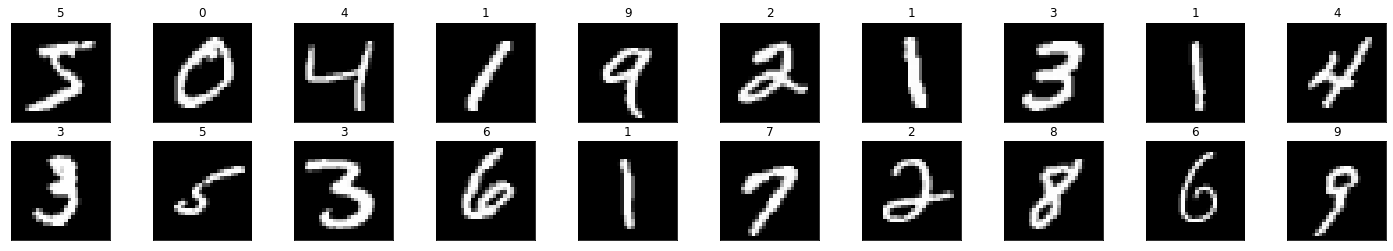

In [49]:
visualize(mnist_data_train)

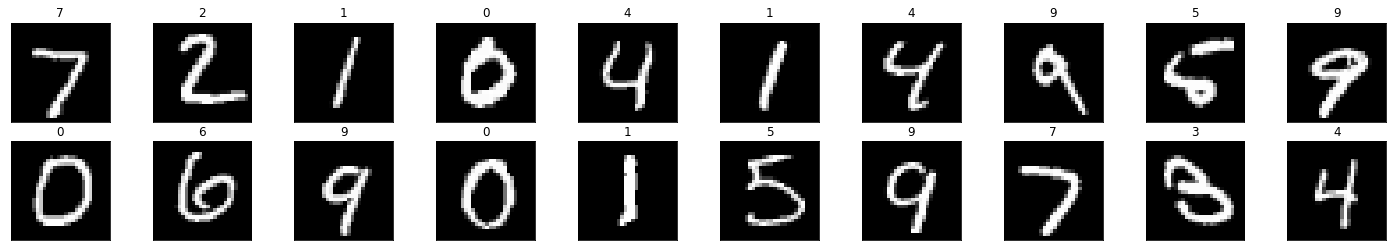

In [50]:
visualize(mnist_data_test)

## Partitioning the Data (IID and non-IID)

In [51]:
def iid_partition(dataset, clients):
  """
  I.I.D paritioning of data over clients
  Shuffle the data
  Split it between clients
  
  params:
    - dataset (torch.utils.Dataset): Dataset containing the MNIST Images
    - clients (int): Number of Clients to split the data between

  returns:
    - Dictionary of image indexes for each client
  """

  num_items_per_client = int(len(dataset)/clients)
  client_dict = {}
  image_idxs = [i for i in range(len(dataset))]

  for i in range(clients):
    client_dict[i] = set(np.random.choice(image_idxs, num_items_per_client, replace=False))
    image_idxs = list(set(image_idxs) - client_dict[i])

  return client_dict

In [52]:
def non_iid_partition(dataset, clients, total_shards, shards_size, num_shards_per_client):
  """
  non I.I.D parititioning of data over clients
  Sort the data by the digit label
  Divide the data into N shards of size S
  Each of the clients will get X shards

  params:
    - dataset (torch.utils.Dataset): Dataset containing the MNIST Images
    - clients (int): Number of Clients to split the data between
    - total_shards (int): Number of shards to partition the data in
    - shards_size (int): Size of each shard 
    - num_shards_per_client (int): Number of shards of size shards_size that each client receives

  returns:
    - Dictionary of image indexes for each client
  """
  
  shard_idxs = [i for i in range(total_shards)]
  client_dict = {i: np.array([], dtype='int64') for i in range(clients)}
  idxs = np.arange(len(dataset))
  data_labels = dataset.targets.numpy()

  # sort the labels
  label_idxs = np.vstack((idxs, data_labels))
  label_idxs = label_idxs[:, label_idxs[1,:].argsort()]
  idxs = label_idxs[0,:]

  # divide the data into total_shards of size shards_size
  # assign num_shards_per_client to each client
  for i in range(clients):
    rand_set = set(np.random.choice(shard_idxs, num_shards_per_client, replace=False))
    shard_idxs = list(set(shard_idxs) - rand_set)

    for rand in rand_set:
      client_dict[i] = np.concatenate((client_dict[i], idxs[rand*shards_size:(rand+1)*shards_size]), axis=0)
  
  return client_dict





## Models

In [53]:
class MNIST_2NN(nn.Module):
  """
  A simple multilayer-perceptron with 2-hidden layers with 200 units each
  using ReLu activations

  Total Expected Params: 199,210
  """
  def __init__(self):
    super(MNIST_2NN, self).__init__()

    self.fc1 = nn.Linear(28*28, 200)
    self.fc2 = nn.Linear(200, 200)
    self.fc3 = nn.Linear(200, 10)

  def forward(self, x):
    x = torch.flatten(x, 1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    out = self.fc3(x)

    return x

In [54]:
class MNIST_CNN(nn.Module):
  """
  CNN with two 5x5 convolution lauers(the first with 32 channels, second with 64,
  each followed with 2x2 max pooling), a fully connected layer with 512 uunits and 
  ReLu activation, and the final Softmax output layer

  Total Expected Params: 1,663,370
  """
  def __init__(self):
    super(MNIST_CNN, self).__init__()

    self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
    
    self.pool = nn.MaxPool2d(2,2)
    self.dropout = nn.Dropout(p=0.2)

    self.fc1 = nn.Linear(1024, 512)
    self.out = nn.Linear(512, 10)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.dropout(x)
    x = torch.flatten(x, 1)
    x = F.relu(self.fc1(x))
    x = self.out(x)
    out = F.log_softmax(x, dim=1)

    return out

### Print Model Summaries

In [55]:
mnist_mlp = MNIST_2NN()
mnist_cnn = MNIST_CNN()

if torch.cuda.is_available():
  mnist_mlp.cuda()
  mnist_cnn.cuda()

print("MNIST MLP SUMMARY")
print(summary(mnist_mlp, (28,28)))

print("\nMNIST CNN SUMMARY")
print(summary(mnist_cnn, (1, 28,28)))

MNIST MLP SUMMARY
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 200]         157,000
            Linear-2                  [-1, 200]          40,200
            Linear-3                   [-1, 10]           2,010
Total params: 199,210
Trainable params: 199,210
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.76
Estimated Total Size (MB): 0.77
----------------------------------------------------------------
None

MNIST CNN SUMMARY
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 24, 24]             832
         MaxPool2d-2           [-1, 32, 12, 12]               0
            Conv2d-3             [-1, 64, 8, 8]          51,264

## FedProx

### Systems Heterogeneity Simulations

Generate epochs for selected clients based on percentage of devices that corresponds to heterogeneity. 

Assign x number of epochs (chosen unifirmly at random between [1, E]) to 0%, 50% or 90% of the selected devices, respectively. Settings where 0% devices perform fewer than E epochs of work correspond to the environments without system heterogeneity, while 90% of the devices sending their partial solutions corresponds to highly heterogenous system.

In [56]:
def GenerateLocalEpochs(percentage, size, max_epochs):
  ''' Method generates list of epochs for selected clients
  to replicate system heteroggeneity

  Params:
    percentage: percentage of clients to have fewer than E epochs
    size:       total size of the list
    max_epochs: maximum value for local epochs
  
  Returns:
    List of size epochs for each Client Update

  '''

  # if percentage is 0 then each client runs for E epochs
  if percentage == 0:
      return np.array([max_epochs]*size)
  else:
    # get the number of clients to have fewer than E epochs
    heterogenous_size = int((percentage/100) * size)

    # generate random uniform epochs of heterogenous size between 1 and E
    epoch_list = np.random.randint(1, max_epochs, heterogenous_size)

    # the rest of the clients will have E epochs
    remaining_size = size - heterogenous_size
    rem_list = [max_epochs]*remaining_size

    epoch_list = np.append(epoch_list, rem_list, axis=0)
    
    # shuffle the list and return
    np.random.shuffle(epoch_list)

    return epoch_list

## Federated Averaging

### Local Training (Client Update)

Local training for the model on client side

In [57]:
class CustomDataset(Dataset):
  def __init__(self, dataset, idxs):
      self.dataset = dataset
      self.idxs = list(idxs)

  def __len__(self):
      return len(self.idxs)

  def __getitem__(self, item):
      image, label = self.dataset[self.idxs[item]]
      return image, label


class ClientUpdate(object):
  def __init__(self, dataset, batchSize, learning_rate, epochs, idxs, mu, algorithm):
    self.train_loader = DataLoader(CustomDataset(dataset, idxs), batch_size=batchSize, shuffle=True)
    self.algorithm = algorithm
    self.learning_rate = learning_rate
    self.epochs = epochs

  def train(self, model):
    criterion = nn.CrossEntropyLoss()
    proximal_criterion = nn.MSELoss(reduction='mean')
    optimizer = torch.optim.SGD(model.parameters(), lr=self.learning_rate, momentum=0.5)

    # use the weights of global model for proximal term calculation
    global_model = copy.deepcopy(model)

    # calculate local training time
    start_time = time.time()


    e_loss = []
    for epoch in range(1, self.epochs+1):

      train_loss = 0.0

      model.train()
      for data, labels in self.train_loader:

        if torch.cuda.is_available():
          data, labels = data.cuda(), labels.cuda()

        # clear the gradients
        optimizer.zero_grad()
        # make a forward pass
        output = model(data)

        # calculate the loss + the proximal term
        _, pred = torch.max(output, 1)

        if self.algorithm == 'fedprox':
          proximal_term = 0.0

          # iterate through the current and global model parameters
          for w, w_t in zip(model.parameters(), global_model.parameters()) :
            # update the proximal term 
            #proximal_term += torch.sum(torch.abs((w-w_t)**2))
            proximal_term += (w-w_t).norm(2)

          loss = criterion(output, labels) + (mu/2)*proximal_term
        else:
          loss = criterion(output, labels)
    
        # do a backwards pass
        loss.backward()
        # perform a single optimization step
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)

      # average losses
      train_loss = train_loss/len(self.train_loader.dataset)
      e_loss.append(train_loss)

    total_loss = sum(e_loss)/len(e_loss)

    return model.state_dict(), total_loss, (time.time() - start_time)

### Server Side Training

Following Algorithm 1 from the paper

In [58]:
def training(model, rounds, batch_size, lr, ds, ds_test, data_dict, C, K, E, mu, percentage, plt_title, plt_color, target_test_accuracy, algorithm="fedprox"):
  """
  Function implements the Federated Averaging Algorithm from the FedAvg paper.
  Specifically, this function is used for the server side training and weight update

  Params:
    - model:           PyTorch model to train
    - rounds:          Number of communication rounds for the client update
    - batch_size:      Batch size for client update training
    - lr:              Learning rate used for client update training
    - ds:              Dataset used for training
    - ds_test:         Dataset used for testing
    - data_dict:       Type of data partition used for training (IID or non-IID)
    - C:               Fraction of clients randomly chosen to perform computation on each round
    - K:               Total number of clients
    - E:               Number of training passes each client makes over its local dataset per round
    - tb_writer_name:  Directory name to save the tensorboard logs
  Returns:
    - model:           Trained model on the server
  """

  # global model weights
  global_weights = model.state_dict()

  # training loss
  # train_accuracy = []
  train_loss = []
  test_accuracy = []
  test_loss = []

  # store last loss for convergence
  last_loss = 0.0

  # total time taken 
  total_time = 0
  start = time.time()
    
  print(f"System heterogeneity set to {percentage}% stragglers.\n")
  print(f"Picking {max(int(C*K),1 )} random clients per round.\n")

  for curr_round in range(1, rounds+1):
    w, local_loss, lst_local_train_time = [], [], []

    m = max(int(C*K), 1)

    heterogenous_epoch_list = GenerateLocalEpochs(percentage, size=m, max_epochs=E)
    heterogenous_epoch_list = np.array(heterogenous_epoch_list)

    S_t = np.random.choice(range(K), m, replace=False)
    S_t = np.array(S_t)
    
    # For Federated Averaging, drop all the clients that are stragglers
    if algorithm == 'fedavg':
      stragglers_indices = np.argwhere(heterogenous_epoch_list < E)
      heterogenous_epoch_list = np.delete(heterogenous_epoch_list, stragglers_indices)
      S_t = np.delete(S_t, stragglers_indices)

    for k, epoch in zip(S_t, heterogenous_epoch_list):
      local_update = ClientUpdate(dataset=ds, batchSize=batch_size, learning_rate=lr, epochs=epoch, idxs=data_dict[k], mu=mu, algorithm=algorithm)
      weights, loss, local_train_time = local_update.train(model=copy.deepcopy(model))

      w.append(copy.deepcopy(weights))
      local_loss.append(copy.deepcopy(loss))
      lst_local_train_time.append(local_train_time)

    # calculate time to update the global weights
    global_start_time = time.time()

    # updating the global weights
    weights_avg = copy.deepcopy(w[0])
    for k in weights_avg.keys():
      for i in range(1, len(w)):
        weights_avg[k] += w[i][k]

      weights_avg[k] = torch.div(weights_avg[k], len(w))

    global_weights = weights_avg
    global_end_time = time.time()

    # calculate total time 
    total_time += (global_end_time - global_start_time) + sum(lst_local_train_time)/len(lst_local_train_time)

    # move the updated weights to our model state dict
    model.load_state_dict(global_weights)

    # loss
    loss_avg = sum(local_loss) / len(local_loss)

    # test accuracy
    criterion = nn.CrossEntropyLoss()
    test_accuracy_current, test_loss_current = testing(copy.deepcopy(model), ds_test, 128, criterion, num_classes, classes_test)
    test_accuracy.append(test_accuracy_current)
    test_loss.append(test_loss_current)

    print(f"Round: {curr_round}... \tAverage Train Loss: {round(loss_avg, 3)}... \tTest Loss: {test_loss_current}... \tTest Accuracy: {test_accuracy_current}")
    train_loss.append(loss_avg)

#     # break if we achieve the target test accuracy
#     if test_accuracy_current >= target_test_accuracy:
#       rounds = curr_round
#       break

    # # break if we achieve convergence, i.e., loss between two consecutive rounds is <0.0001
    # if algorithm == 'fedprox' and abs(loss_avg - last_loss) < 0.0001:
    #   rounds = curr_round
    #   break
    
    # update the last loss
    last_loss = loss_avg

  end = time.time()

  # plot train loss
  fig, ax = plt.subplots()
  x_axis = np.arange(1, rounds+1)
  y_axis = np.array(train_loss)
  ax.plot(x_axis, y_axis)

  ax.set(xlabel='Number of Rounds', ylabel='Train Loss', title=plt_title)
  ax.grid()
  fig.savefig(plt_title+'_Train_loss.jpg', format='jpg')
  plt.show()

  fig, ax = plt.subplots()
  x_axis = np.arange(1, rounds+1)
  y_axis = np.array(test_loss)
  ax.plot(x_axis, y_axis, 'tab:'+plt_color)

  ax.set(xlabel='Number of Rounds', ylabel='Test Loss', title=plt_title)
  ax.grid()
  fig.savefig(plt_title+'_Test_loss.jpg', format='jpg')
  plt.show()


  fig, ax = plt.subplots()
  x_axis = np.arange(1, rounds+1)
  y_axis = np.array(test_accuracy)
  ax.plot(x_axis, y_axis, 'tab:'+plt_color)

  ax.set(xlabel='Number of Rounds', ylabel='Test Accuracy', title=plt_title)
  ax.grid()
  fig.savefig(plt_title+'_Test_Accuracy.jpg', format='jpg')
  plt.show()
  
  print("Training Done!")
  print("Total time taken to Train: {}\n\n".format(end-start))
  
  return model, train_loss, test_accuracy, test_loss

## Testing Loop

In [59]:
def testing(model, dataset, bs, criterion, num_classes, classes, print_info=False):
  #test loss 
  test_loss = 0.0
  correct_class = list(0. for i in range(num_classes))
  total_class = list(0. for i in range(num_classes))

  test_loader = DataLoader(dataset, batch_size=bs)
  l = len(test_loader)
  model.eval()
  for data, labels in test_loader:

    if torch.cuda.is_available():
      data, labels = data.cuda(), labels.cuda()

    output = model(data)
    loss = criterion(output, labels)
    test_loss += loss.item()*data.size(0)

    _, pred = torch.max(output, 1)

    correct_tensor = pred.eq(labels.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())

    #test accuracy for each object class
    for i in range(num_classes):
      label = labels.data[i]
      correct_class[label] += correct[i].item()
      total_class[label] += 1
    
  # avg test loss
  test_loss = test_loss/len(test_loader.dataset)
  test_accuracy = 100. * np.sum(correct_class) / np.sum(total_class)

  if print_info:
    print("Test Loss: {:.6f}\n".format(test_loss))

    for i in range(10):
      if total_class[i]>0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % 
              (classes[i], 100 * correct_class[i] / total_class[i],
              np.sum(correct_class[i]), np.sum(total_class[i])))
      else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

    print('\nFinal Test  Accuracy: {:.3f} ({}/{})'.format(
          100. * np.sum(correct_class) / np.sum(total_class),
          np.sum(correct_class), np.sum(total_class)))
  
  return test_accuracy, test_loss

## Logger

In [60]:
log_dict = {}
NUM_REPEAT = 1

## MNIST CNN on IID

### Train


Experiment Run Number:  0
System heterogeneity set to 50% stragglers.

Picking 90 random clients per round.

Round: 1... 	Average Train Loss: 0.777... 	Test Loss: 0.4728694719314575... 	Test Accuracy: 93.54430379746836
Round: 2... 	Average Train Loss: 0.24... 	Test Loss: 0.10595247623547911... 	Test Accuracy: 96.70886075949367
Round: 3... 	Average Train Loss: 0.144... 	Test Loss: 0.07972730276025831... 	Test Accuracy: 96.9620253164557
Round: 4... 	Average Train Loss: 0.115... 	Test Loss: 0.06571214165212587... 	Test Accuracy: 97.59493670886076
Round: 5... 	Average Train Loss: 0.096... 	Test Loss: 0.05782889560176991... 	Test Accuracy: 97.9746835443038
Round: 6... 	Average Train Loss: 0.083... 	Test Loss: 0.05221650475396309... 	Test Accuracy: 98.60759493670886
Round: 7... 	Average Train Loss: 0.082... 	Test Loss: 0.04704525838163681... 	Test Accuracy: 98.48101265822785
Round: 8... 	Average Train Loss: 0.073... 	Test Loss: 0.04371374118784443... 	Test Accuracy: 99.11392405063292
Round: 

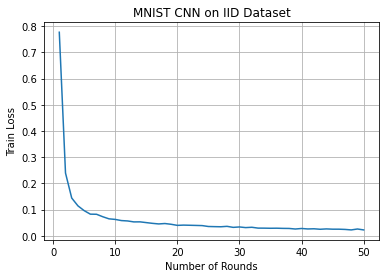

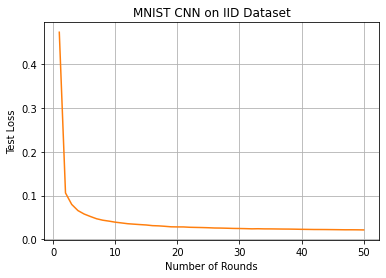

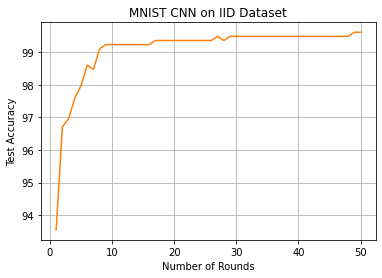

Training Done!
Total time taken to Train: 4851.092745780945




In [61]:
train_loss_multiple_runs = [None] * NUM_REPEAT
test_accuracy_multiple_runs = [None] * NUM_REPEAT
test_loss_multiple_runs = [None] * NUM_REPEAT

for exp_num in range(NUM_REPEAT):
  print("Experiment Run Number: ", exp_num)

  # number of training rounds
  rounds = 50
  # client fraction
  C = 0.9
  # number of clients
  K = 100
  # number of training passes on local dataset for each roung
  E = 5
  # batch size
  batch_size = 10
  # learning Rate
  lr = 0.05
  # proximal term constant
  mu = 0.01
  # percentage of clients to have fewer than E epochs
  percentage = 50

  # target_test_accuracy
  target_test_accuracy=99.0
  # data partition dictionary
  iid_dict = iid_partition(mnist_data_train, 100)
  # load model
  mnist_cnn = MNIST_CNN()

  if torch.cuda.is_available():
    mnist_cnn.cuda()

  mnist_cnn_iid_trained, train_loss, test_accuracy, test_loss = training(mnist_cnn, rounds, batch_size, lr, mnist_data_train, mnist_data_test, iid_dict, C, K, E, mu, percentage, "MNIST CNN on IID Dataset", "orange", target_test_accuracy)

  train_loss_multiple_runs[exp_num] = train_loss
  test_accuracy_multiple_runs[exp_num] = test_accuracy
  test_loss_multiple_runs[exp_num] = test_loss

### Test

In [62]:
criterion = nn.CrossEntropyLoss()
acc, loss = testing(mnist_cnn_iid_trained, mnist_data_test, 128, criterion, num_classes, classes_test, True)

Test Loss: 0.021547

Test Accuracy of     0: 100% (76/76)
Test Accuracy of     1: 100% (90/90)
Test Accuracy of     2: 100% (91/91)
Test Accuracy of     3: 97% (71/73)
Test Accuracy of     4: 100% (89/89)
Test Accuracy of     5: 98% (67/68)
Test Accuracy of     6: 100% (62/62)
Test Accuracy of     7: 100% (81/81)
Test Accuracy of     8: 100% (77/77)
Test Accuracy of     9: 100% (83/83)

Final Test  Accuracy: 99.620 (787.0/790.0)


In [63]:
hyperparams = {'rounds': rounds,
               'C': C,
               'K': K,
               'E': E,
               'batch_size': batch_size,
               'lr': lr,
               'mu': mu,
               'percentage': percentage,
               'target_test_accuracy': target_test_accuracy,
               }

log_dict['MNIST CNN on IID'] = {'train_loss': train_loss_multiple_runs, 
                                'test_loss': test_loss_multiple_runs, 
                                'test_accuracy': test_accuracy_multiple_runs,
                                'hyperparams': hyperparams,
                                }

## MNIST CNN on Non IID

### Train


Experiment Run Number:  0
System heterogeneity set to 50% stragglers.

Picking 90 random clients per round.

Round: 1... 	Average Train Loss: 0.181... 	Test Loss: 2.220987812423706... 	Test Accuracy: 38.860759493670884
Round: 2... 	Average Train Loss: 0.136... 	Test Loss: 1.875371176147461... 	Test Accuracy: 79.62025316455696
Round: 3... 	Average Train Loss: 0.076... 	Test Loss: 1.0836788633346557... 	Test Accuracy: 88.9873417721519
Round: 4... 	Average Train Loss: 0.055... 	Test Loss: 0.6745660373687744... 	Test Accuracy: 90.75949367088607
Round: 5... 	Average Train Loss: 0.05... 	Test Loss: 0.4773162147045136... 	Test Accuracy: 93.67088607594937
Round: 6... 	Average Train Loss: 0.042... 	Test Loss: 0.35864794974327086... 	Test Accuracy: 94.30379746835443
Round: 7... 	Average Train Loss: 0.036... 	Test Loss: 0.2746884248018265... 	Test Accuracy: 95.69620253164557
Round: 8... 	Average Train Loss: 0.039... 	Test Loss: 0.2296572071790695... 	Test Accuracy: 95.82278481012658
Round: 9... 	

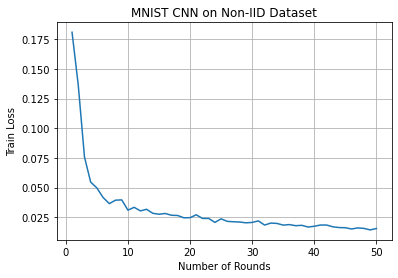

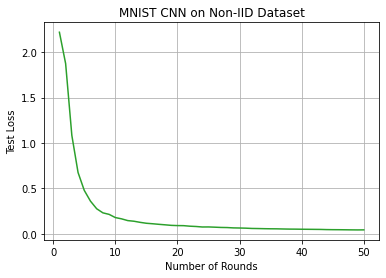

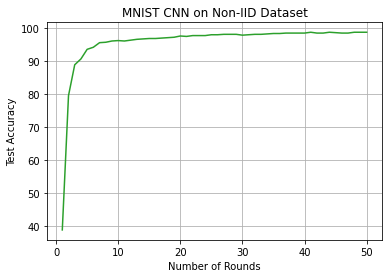

Training Done!
Total time taken to Train: 4990.625168561935




In [64]:
train_loss_multiple_runs = [None] * NUM_REPEAT
test_accuracy_multiple_runs = [None] * NUM_REPEAT
test_loss_multiple_runs = [None] * NUM_REPEAT

for exp_num in range(NUM_REPEAT):
  print("Experiment Run Number: ", exp_num)

  # number of training rounds
  rounds = 50
  # client fraction
  C = 0.9
  # number of clients
  K = 100
  # number of training passes on local dataset for each roung
  E = 5
  # batch size
  batch_size = 10
  # learning Rate
  lr=0.05
  # proximal term constant
  mu = 0.01
  # percentage of clients to have fewer than E epochs
  percentage = 50
  # target_test_accuracy
  target_test_accuracy=99.0

  # dict containing different type of data partition
  data_dict = non_iid_partition(mnist_data_train, 100, 200, 300, 2)
  # load model
  mnist_cnn = MNIST_CNN()

  if torch.cuda.is_available():
    mnist_cnn.cuda()

  mnist_cnn_non_iid_trained, train_loss, test_accuracy, test_loss = training(mnist_cnn, rounds, batch_size, lr, mnist_data_train, mnist_data_test, data_dict, C, K, E,mu, percentage, "MNIST CNN on Non-IID Dataset", "green", target_test_accuracy)

  train_loss_multiple_runs[exp_num] = train_loss
  test_accuracy_multiple_runs[exp_num] = test_accuracy
  test_loss_multiple_runs[exp_num] = test_loss

### Test

In [65]:
criterion = nn.CrossEntropyLoss()
acc, loss = testing(mnist_cnn_non_iid_trained, mnist_data_test, 128, criterion, num_classes, classes_test, True)

Test Loss: 0.041950

Test Accuracy of     0: 97% (74/76)
Test Accuracy of     1: 100% (90/90)
Test Accuracy of     2: 100% (91/91)
Test Accuracy of     3: 97% (71/73)
Test Accuracy of     4: 98% (88/89)
Test Accuracy of     5: 98% (67/68)
Test Accuracy of     6: 98% (61/62)
Test Accuracy of     7: 98% (80/81)
Test Accuracy of     8: 100% (77/77)
Test Accuracy of     9: 98% (82/83)

Final Test  Accuracy: 98.861 (781.0/790.0)


In [66]:
hyperparams = {'rounds': rounds,
               'C': C,
               'K': K,
               'E': E,
               'batch_size': batch_size,
               'lr': lr,
               'mu': mu,
               'percentage': percentage,
               'target_test_accuracy': target_test_accuracy,
               }

log_dict['MNIST CNN on Non IID'] = {'train_loss': train_loss_multiple_runs, 
                                'test_loss': test_loss_multiple_runs, 
                                'test_accuracy': test_accuracy_multiple_runs,
                                'hyperparams': hyperparams,
                                }

## MNIST MLP on IID

### Train

Experiment Run Number:  0
System heterogeneity set to 50% stragglers.

Picking 90 random clients per round.

Round: 1... 	Average Train Loss: 0.981... 	Test Loss: 0.35649055855274203... 	Test Accuracy: 90.37974683544304
Round: 2... 	Average Train Loss: 0.273... 	Test Loss: 0.25568000934422014... 	Test Accuracy: 93.41772151898734
Round: 3... 	Average Train Loss: 0.212... 	Test Loss: 0.21936441533863543... 	Test Accuracy: 94.43037974683544
Round: 4... 	Average Train Loss: 0.174... 	Test Loss: 0.19430462203323842... 	Test Accuracy: 94.68354430379746
Round: 5... 	Average Train Loss: 0.156... 	Test Loss: 0.1737713628128171... 	Test Accuracy: 94.68354430379746
Round: 6... 	Average Train Loss: 0.132... 	Test Loss: 0.16163766304180027... 	Test Accuracy: 95.31645569620254
Round: 7... 	Average Train Loss: 0.131... 	Test Loss: 0.15070732349306346... 	Test Accuracy: 95.69620253164557
Round: 8... 	Average Train Loss: 0.119... 	Test Loss: 0.1425728899911046... 	Test Accuracy: 95.56962025316456
Round

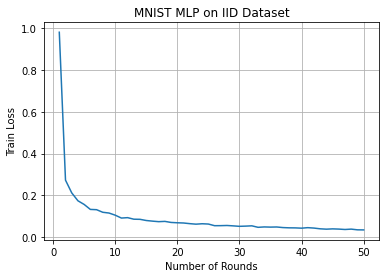

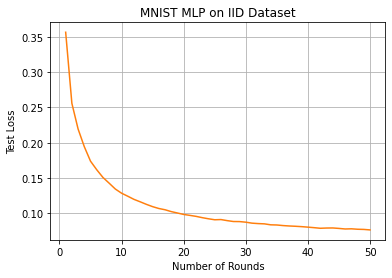

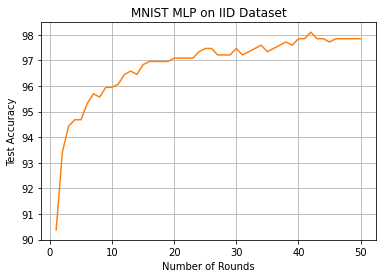

Training Done!
Total time taken to Train: 3553.461055278778




In [67]:
train_loss_multiple_runs = [None] * NUM_REPEAT
test_accuracy_multiple_runs = [None] * NUM_REPEAT
test_loss_multiple_runs = [None] * NUM_REPEAT

for exp_num in range(NUM_REPEAT):
  print("Experiment Run Number: ", exp_num)

  # number of training rounds
  rounds = 50
  # client fraction
  C = 0.9
  # number of clients
  K = 100
  # number of training passes on local dataset for each round
  E = 5
  # batch size
  batch_size = 10
  # learning Rate
  lr = 0.05
  # proximal term constant
  mu = 0.01
  # percentage of clients to have fewer than E epochs
  percentage = 50
  # target_test_accuracy
  target_test_accuracy=94.0
  # dict containing different type of data partition
  data_dict = iid_partition(mnist_data_train, 100)
  # load model
  mnist_mlp = MNIST_2NN()

  if torch.cuda.is_available():
    mnist_mlp.cuda()

  mnist_mlp_iid_trained, train_loss, test_accuracy, test_loss = training(mnist_mlp, rounds, batch_size, lr, mnist_data_train, mnist_data_test, data_dict, C, K, E, mu, percentage, "MNIST MLP on IID Dataset", "orange", target_test_accuracy)
  
  train_loss_multiple_runs[exp_num] = train_loss
  test_accuracy_multiple_runs[exp_num] = test_accuracy
  test_loss_multiple_runs[exp_num] = test_loss

### Test

In [68]:
criterion = nn.CrossEntropyLoss()
acc, loss = testing(mnist_mlp_iid_trained, mnist_data_test, 128, criterion, num_classes, classes_test, True)

Test Loss: 0.076341

Test Accuracy of     0: 98% (75/76)
Test Accuracy of     1: 97% (88/90)
Test Accuracy of     2: 96% (88/91)
Test Accuracy of     3: 98% (72/73)
Test Accuracy of     4: 97% (87/89)
Test Accuracy of     5: 97% (66/68)
Test Accuracy of     6: 96% (60/62)
Test Accuracy of     7: 97% (79/81)
Test Accuracy of     8: 100% (77/77)
Test Accuracy of     9: 97% (81/83)

Final Test  Accuracy: 97.848 (773.0/790.0)


In [69]:
hyperparams = {'rounds': rounds,
               'C': C,
               'K': K,
               'E': E,
               'batch_size': batch_size,
               'lr': lr,
               'mu': mu,
               'percentage': percentage,
               'target_test_accuracy': target_test_accuracy,
               }

log_dict['MNIST MLP on IID'] = {'train_loss': train_loss_multiple_runs, 
                                'test_loss': test_loss_multiple_runs, 
                                'test_accuracy': test_accuracy_multiple_runs,
                                'hyperparams': hyperparams,
                                }

## MNIST MLP on Non IID

### Train

Experiment Run Number:  0
System heterogeneity set to 50% stragglers.

Picking 90 random clients per round.

Round: 1... 	Average Train Loss: 0.204... 	Test Loss: 3.3372332431793215... 	Test Accuracy: 63.164556962025316
Round: 2... 	Average Train Loss: 0.106... 	Test Loss: 1.6604577470779418... 	Test Accuracy: 77.59493670886076
Round: 3... 	Average Train Loss: 0.091... 	Test Loss: 0.9491326570510864... 	Test Accuracy: 84.81012658227849
Round: 4... 	Average Train Loss: 0.078... 	Test Loss: 0.679967012500763... 	Test Accuracy: 85.44303797468355
Round: 5... 	Average Train Loss: 0.068... 	Test Loss: 0.5364539153575897... 	Test Accuracy: 88.22784810126582
Round: 6... 	Average Train Loss: 0.061... 	Test Loss: 0.45942066547870636... 	Test Accuracy: 88.73417721518987
Round: 7... 	Average Train Loss: 0.06... 	Test Loss: 0.40855088884830476... 	Test Accuracy: 89.74683544303798
Round: 8... 	Average Train Loss: 0.056... 	Test Loss: 0.37111515707969667... 	Test Accuracy: 91.0126582278481
Round: 9..

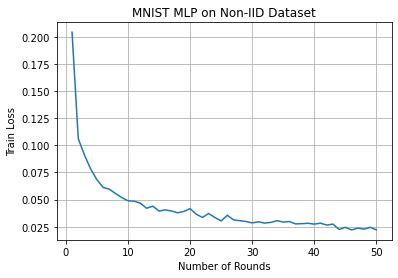

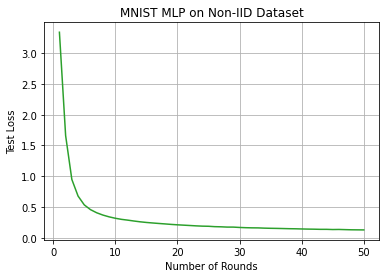

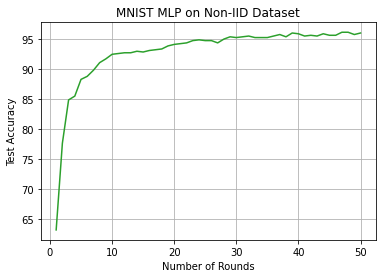

Training Done!
Total time taken to Train: 3476.585467338562




In [70]:
train_loss_multiple_runs = [None] * NUM_REPEAT
test_accuracy_multiple_runs = [None] * NUM_REPEAT
test_loss_multiple_runs = [None] * NUM_REPEAT

for exp_num in range(NUM_REPEAT):
  print("Experiment Run Number: ", exp_num)
  
  # number of training rounds
  rounds = 50
  # client fraction
  C = 0.9
  # number of clients
  K = 100
  # number of training passes on local dataset for each roung
  E = 5
  # batch size
  batch_size = 10
  # learning Rate
  lr=0.05
  # proximal term constant
  mu = 0.01
  # percentage of clients to have fewer than E epochs
  percentage = 50
  # target_test_accuracy
  target_test_accuracy=94.0
  # dict containing different type of data partition
  data_dict = non_iid_partition(mnist_data_train, 100, 200, 300, 2)
  # load model
  mnist_mlp = MNIST_2NN()

  if torch.cuda.is_available():
    mnist_mlp.cuda()

  mnist_mlp_non_iid_trained, train_loss, test_accuracy, test_loss = training(mnist_mlp, rounds, batch_size, lr, mnist_data_train, mnist_data_test, data_dict, C, K, E, mu, percentage, "MNIST MLP on Non-IID Dataset", "green", target_test_accuracy)

  train_loss_multiple_runs[exp_num] = train_loss
  test_accuracy_multiple_runs[exp_num] = test_accuracy
  test_loss_multiple_runs[exp_num] = test_loss

### Test

In [71]:
criterion = nn.CrossEntropyLoss()
acc, loss = testing(mnist_mlp_non_iid_trained, mnist_data_test, 128, criterion, num_classes, classes_test, True)

Test Loss: 0.130296

Test Accuracy of     0: 96% (73/76)
Test Accuracy of     1: 97% (88/90)
Test Accuracy of     2: 95% (87/91)
Test Accuracy of     3: 97% (71/73)
Test Accuracy of     4: 97% (87/89)
Test Accuracy of     5: 94% (64/68)
Test Accuracy of     6: 95% (59/62)
Test Accuracy of     7: 92% (75/81)
Test Accuracy of     8: 97% (75/77)
Test Accuracy of     9: 95% (79/83)

Final Test  Accuracy: 95.949 (758.0/790.0)


In [72]:
hyperparams = {'rounds': rounds,
               'C': C,
               'K': K,
               'E': E,
               'batch_size': batch_size,
               'lr': lr,
               'mu': mu,
               'percentage': percentage,
               'target_test_accuracy': target_test_accuracy,
               }

log_dict['MNIST MLP on Non IID'] = {'train_loss': train_loss_multiple_runs, 
                                'test_loss': test_loss_multiple_runs, 
                                'test_accuracy': test_accuracy_multiple_runs,
                                'hyperparams': hyperparams,
                                }

## Pickle Log

In [73]:
import pickle
 
with open(path + 'FedProx_0.9.pkl', 'wb') as file:
  pickle.dump(log_dict, file)

In [74]:
log_dict

{'MNIST CNN on IID': {'hyperparams': {'C': 0.9,
   'E': 5,
   'K': 100,
   'batch_size': 10,
   'lr': 0.05,
   'mu': 0.01,
   'percentage': 50,
   'rounds': 50,
   'target_test_accuracy': 99.0},
  'test_accuracy': [[93.54430379746836,
    96.70886075949367,
    96.9620253164557,
    97.59493670886076,
    97.9746835443038,
    98.60759493670886,
    98.48101265822785,
    99.11392405063292,
    99.24050632911393,
    99.24050632911393,
    99.24050632911393,
    99.24050632911393,
    99.24050632911393,
    99.24050632911393,
    99.24050632911393,
    99.24050632911393,
    99.36708860759494,
    99.36708860759494,
    99.36708860759494,
    99.36708860759494,
    99.36708860759494,
    99.36708860759494,
    99.36708860759494,
    99.36708860759494,
    99.36708860759494,
    99.36708860759494,
    99.49367088607595,
    99.36708860759494,
    99.49367088607595,
    99.49367088607595,
    99.49367088607595,
    99.49367088607595,
    99.49367088607595,
    99.49367088607595,
    99.4

In [75]:
import pickle

with open(path + 'FedProx_0.9.pkl', 'rb') as file:
  log_dict = pickle.load(file)

In [76]:
print([test_acc[-1] for test_acc in log_dict['MNIST CNN on IID']['test_accuracy']])

[99.62025316455696]


In [77]:
print([test_acc[-1] for test_acc in log_dict['MNIST CNN on Non IID']['test_accuracy']])

[98.86075949367088]


In [78]:
print([test_acc[-1] for test_acc in log_dict['MNIST MLP on IID']['test_accuracy']])

[97.84810126582279]


In [79]:
print([test_acc[-1] for test_acc in log_dict['MNIST MLP on Non IID']['test_accuracy']])

[95.9493670886076]


In [80]:
output.show()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
